# Movie Recommendation System -  Mid Program Project


### Import Library and Load the Datasets

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_movies = pd.read_csv('movies.csv')
data_ratings = pd.read_csv('ratings.csv')

print(data_movies.head())
print(data_ratings.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating   timestamp
0       1       16     4.0  1217897793
1       1       24     1.5  1217895807
2       1       32     4.0  1217896246
3       1       47     4.0  1217896556
4       1       50     4.0  1217896523


## Exploratory Data Analysis 

### Distribution of ratings

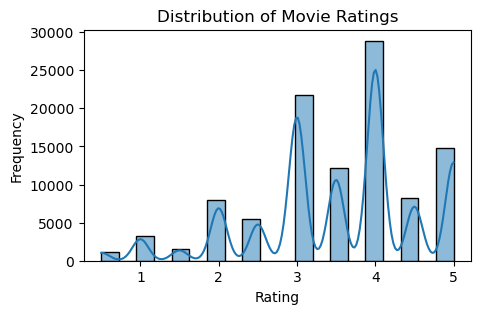

In [118]:

plt.figure(figsize=(5, 3))
sns.histplot(data_ratings['rating'], bins = 20, kde = True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


### Unique User and Movies

In [120]:
num_users = data_ratings['userId'].nunique()
num_movies = data_ratings['movieId'].nunique()

print(f' Unique Users : {num_users}')
print(f' Unique Movies : {num_movies}')

 Unique Users : 668
 Unique Movies : 10325


### Average Rating and Total Movies at Genre Level

In [186]:
genres_count = data_movies['genres'].str.get_dummies(sep='|').sum()
average_rating_per_genre = data_ratings.merge(data_movies, on='movieId').groupby('genres')['rating'].mean()
print(f'Genre Count: "{genres_count} ')

Genre Count: "(no genres listed)       7
Action                1737
Adventure             1164
Animation              401
Children               540
Comedy                3515
Crime                 1440
Documentary            415
Drama                 5220
Fantasy                670
Film-Noir              195
Horror                1001
IMAX                   152
Musical                409
Mystery                675
Romance               1788
Sci-Fi                 860
Thriller              2187
War                    503
Western                235
dtype: int64 


### Unique Genres

In [234]:
unique_genres = data_movies['genres'].str.cat(sep='|').split('|')
unique_genres = set(unique_genres)
print(f'Unique Genres: {len(unique_genres)}')


Unique Genres: 20


### 1. Create a popularity basedrecommender system at a genre level. User will input a genre (g), minimum ratings threshold (t) for a movie and no. of recommendations(N) for which it should be recommended top N movies which are most popular within that genre (g) ordered by ratings in descending order where each movie has at least (t) reviews.

In [194]:
def popularity_based_recommender(genre, min_reviews, num_recommendations):
    # Filter movies by genre
    genre_movies = data_movies[data_movies['genres'].str.contains(genre)]
    
    # Filter ratings for those movies
    genre_ratings = data_ratings[data_ratings['movieId'].isin(genre_movies['movieId'])]
    
    # Group by movieId, calculate average rating and number of reviews
    popular_movies = genre_ratings.groupby('movieId').agg(
        avg_rating=('rating', 'mean'),
        num_reviews=('rating', 'count')
    ).reset_index()
    
    # Filter movies with at least min_reviews
    popular_movies = popular_movies[popular_movies['num_reviews'] >= min_reviews]
    
    # Merge with movie data to get movie titles
    popular_movies = popular_movies.merge(data_movies, on='movieId')
    
    # Sort by average rating and limit to num_recommendations
    popular_movies = popular_movies.sort_values(by='avg_rating', ascending=False).head(num_recommendations)
    
    # Reset index to start S.No. from 1
    popular_movies = popular_movies.reset_index(drop=True)
    popular_movies['S.No.'] = popular_movies.index + 1
    
    # Return desired columns with S.No.
    return popular_movies[['S.No.', 'title', 'avg_rating', 'num_reviews']].to_string(index=False)


print(popularity_based_recommender('Comedy', 100, 5))



 S.No.                                  title  avg_rating  num_reviews
     1 Monty Python and the Holy Grail (1975)    4.301948          154
     2                           Fargo (1996)    4.271144          201
     3             Princess Bride, The (1987)    4.163743          171
     4                    Pulp Fiction (1994)    4.160000          325
     5                    Forrest Gump (1994)    4.138264          311


### 2.Create a content basedrecommender system which recommends top N moviesbased on similar movie(m) genres.

In [228]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

def content_based_recommender(movie_title, num_recommendations=5):    
    tfidf = TfidfVectorizer(stop_words='english')
    data_movies['genres'] = data_movies['genres'].fillna('')  
    tfidf_matrix = tfidf.fit_transform(data_movies['genres'])    
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    indices = pd.Series(data_movies.index, index=data_movies['title']).drop_duplicates()
    if movie_title not in indices:
        return f"Movie '{movie_title}' not found."
    idx = indices[movie_title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations + 1]
    movie_indices = [i[0] for i in sim_scores]
    recommended_titles = data_movies['title'].iloc[movie_indices].reset_index(drop=True)
    result = pd.DataFrame({'S.No': range(1, len(recommended_titles) + 1), 'Movie Title': recommended_titles}).to_string(index=False)    
    return result

recommended_movies = content_based_recommender('Four Rooms (1995)', 5)
print(recommended_movies)

 S.No                           Movie Title
    1                     Four Rooms (1995)
    2 Ace Ventura: When Nature Calls (1995)
    3                       Bio-Dome (1996)
    4                         Friday (1995)
    5                    Black Sheep (1996)


### 3.Create a collaborative based recommender system which recommends top Nmovies based on “K” similar users for a target user “u”

In [285]:
from sklearn.neighbors import NearestNeighbors

def collaborative_filtering_recommender(user_id, num_recommendations, threshold):
    user_ratings = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
  
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(user_ratings)
    
    distances, indices = model_knn.kneighbors(user_ratings.loc[user_id].values.reshape(1, -1), n_neighbors=threshold+1)
    
    similar_users = [user_ratings.index[i] for i in indices.flatten()[1:]]
    similar_user_movies = ratings[ratings['userId'].isin(similar_users)]
    
    recommendations = (similar_user_movies.groupby('movieId').agg({'rating': 'mean', 'userId': 'count'}).rename(columns={'userId': 'num_reviews'}).reset_index())
    recommendations = recommendations[recommendations['num_reviews'] >= 1] 
    recommendations = recommendations.sort_values(by='rating', ascending=False).head(num_recommendations)
    recommended_movies = movies[movies['movieId'].isin(recommendations['movieId'])]
    
    return recommended_movies[['title']]

print(collaborative_filtering_recommender(1, 5, 100))


                             title
391   Endless Summer 2, The (1994)
2367            Fever Pitch (1997)
3202    The Man in the Moon (1991)
3823         In the Bedroom (2001)
5472  School For Scoundrels (1960)


### 4.Additional/Optional: Create a GUI interface using Python libraries (ipywidgetsetc.) to play around with the recommendation modules.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

genre_input = widgets.Text(description='Genre:')
min_reviews_input = widgets.IntSlider(value=100, min=0, max=500, description='Min Reviews:')
num_recommendations_input = widgets.IntSlider(value=5, min=1, max=20, description='Num Recommendations:')

output = widgets.Output()

def on_button_click(b):
    with output:
        clear_output() 
        recommendations = popularity_based_recommender(genre_input.value, min_reviews_input.value, num_recommendations_input.value)
        print(recommendations)

button = widgets.Button(description='Get Recommendations')
button.on_click(on_button_click)

display(genre_input, min_reviews_input, num_recommendations_input, button, output)
